# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [ ]:
!nvidia-smi

Mon Oct 11 09:27:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.20       Driver Version: 457.20       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P8    15W /  N/A |    681MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !mkdir -p /content/drive/MyDrive/ML2021-hw6/

# You may replace the workspace directory if you want.
# workspace_dir = '/content/drive/MyDrive/ML2021-hw6'
workspace_dir = '.'

# Training progress bar
# !pip install -q qqdm
# Stylegan2
# !pip install --user stylegan2_pytorch

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [4]:
# !gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"

###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [5]:
# !unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Random seed
Set the random seed to a certain value for reproducibility.

In [6]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1116)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [7]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm
import os

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [8]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

In [12]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

# images = [dataset[i] for i in range(16)]
# grid_img = torchvision.utils.make_grid(images, nrow=4)
# plt.figure(figsize=(10,10))
# plt.imshow(grid_img.permute(1, 2, 0))
# plt.show()

In [11]:
# images = [(dataset[i]+1)/2 for i in range(16)]
# grid_img = torchvision.utils.make_grid(images, nrow=4)
# plt.figure(figsize=(10,10))
# plt.imshow(grid_img.permute(1, 2, 0))
# plt.show()

NameError: name 'dataset' is not defined

## Training

'export' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [14]:
!stylegan2_pytorch --data ./faces --name stylegan2 --models_dir ./models --results_dir ./results --image-size 64 --num-train-steps 100000 --num-workers 8 --network-capacity 256

^C


## Inference
Use the trained model to generate anime faces!

### Generate and show some images.


continuing from previous epoch - 100
loading from version 1.8.1


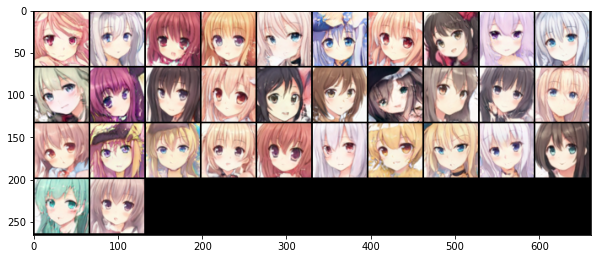

In [14]:
# Generate 1000 images and make a grid to save them.
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = './hw6',   # path to where you invoked the command line tool
    name = 'stylegan2'                             # the project name, defaults to 'default'
)


n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  # pass through mapping network

# Show 32 of the images.
imgs_sample = loader.styles_to_images(styles[:32])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [15]:
# Save the generated images.
os.makedirs('/content/drive/MyDrive/ML2021-hw6/output/', exist_ok=True)
eval_batch_size = 100

for i in range(10):
    images = loader.styles_to_images(styles[i*eval_batch_size:(i+1)*eval_batch_size])
    for j in range(eval_batch_size):
        save_image(images[j], f'/content/drive/MyDrive/ML2021-hw6/output/{i*eval_batch_size+j+1}.jpg') # save your images, or do whatever you desire

# Compress the images.
%cd /content/drive/MyDrive/ML2021-hw6/output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/drive/MyDrive/ML2021-hw6/output
/content/drive/MyDrive/ML2021-hw6


# References

1. I modify the sample code from TA of machine learning course at NTU
2. StyleGAN2 is from https://github.com/lucidrains/stylegan2-pytorch
